# 2. Model Train

## Model ResNet50

### Import libraries

In [2]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
with open('model_Resnet50_on_Original_Images','rb') as f:
    model = pickle.load(f)

In [3]:
np.random.seed(12049)

In [29]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()


def compute_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")


def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

### Load data

In [5]:
train_path = r"Knee_Dataset\processed_data\train"
valid_path = r"Knee_Dataset\processed_data\val"
test_path = r"Knee_Dataset\processed_data\test"

### Definitions

In [6]:
model_name = "ResNet50"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model_ft = os.path.join('models', f'model_{model_name}_ft.hdf5')

### Image data generator

In [7]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [8]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 4546 images belonging to 5 classes.
Found 566 images belonging to 5 classes.


In [9]:
y_train = train_generator.labels
y_val = valid_generator.labels

### Weight data

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 1828, 1: 763, 2: 1212, 3: 605, 4: 138}
{0: 0.4973741794310722, 1: 1.1916120576671034, 2: 0.7501650165016501, 3: 1.502809917355372, 4: 6.58840579710145}


### Train data

In [11]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01, 
                min_lr=1e-10, patience=4, mode='auto'
            )

In [12]:
model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

### Fine-tuning

In [13]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 23544837 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [14]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100
143/143 [==============================] - 1455s 10s/step - loss: 1.6815 - accuracy: 0.2563 - val_loss: 22.7989 - val_accuracy: 0.4028 - lr: 0.0010
Epoch 2/100
143/143 [==============================] - 1444s 10s/step - loss: 1.2365 - accuracy: 0.3731 - val_loss: 18.4695 - val_accuracy: 0.1325 - lr: 0.0010
Epoch 3/100
143/143 [==============================] - 1454s 10s/step - loss: 1.1809 - accuracy: 0.3880 - val_loss: 4.5529 - val_accuracy: 0.1802 - lr: 0.0010
Epoch 4/100
143/143 [==============================] - 1443s 10s/step - loss: 1.0959 - accuracy: 0.4114 - val_loss: 1.4193 - val_accuracy: 0.4594 - lr: 0.0010
Epoch 5/100
143/143 [==============================] - 1428s 10s/step - loss: 1.0654 - accuracy: 0.4600 - val_loss: 1.3745 - val_accuracy: 0.4929 - lr: 0.0010
Epoch 6/100
143/143 [==============================] - 1729s 12s/step - loss: 1.0129 - accuracy: 0.4547 - val_loss: 2.4345 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 7/100
143/143 [=======================

In [30]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model ResNet50 fine tuning executed in 521.14 minutes


In [31]:
import pickle
with open('model_Resnet50_on_Original_Images','wb') as f:
    pickle.dump(model,f)

In [33]:
get_evaluate(valid_generator, "Valid", model_ft)

18/18 [==============================] - 44s 2s/step - loss: 1.0429 - accuracy: 0.5689
Valid loss: 1.04
Valid accuracy: 0.57


In [34]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

18/18 [==============================] - 38s 2s/step
Accuracy Score - ResNet50: 0.57
Balanced Accuracy Score - ResNet50: 0.55


              precision    recall  f1-score   support

           0       0.59      0.89      0.71       228
           1       0.21      0.05      0.08        95
           2       0.60      0.35      0.44       151
           3       0.59      0.64      0.61        75
           4       0.44      0.82      0.57        17

    accuracy                           0.57       566
   macro avg       0.49      0.55      0.48       566
weighted avg       0.53      0.57      0.52       566



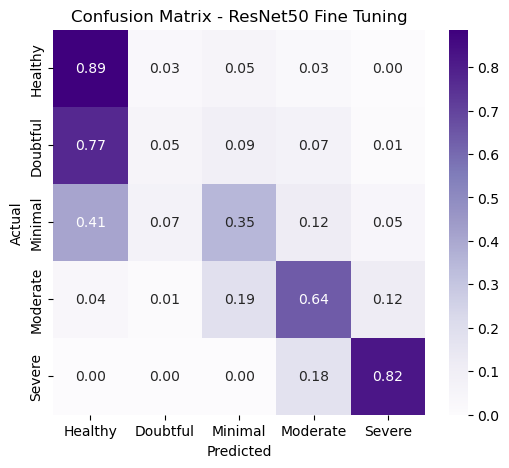

In [35]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)

In [36]:
import cv2

In [37]:
image = cv2.imread('C:/Users/sahil/Unet Implementation/Knee Osteoarthritis Cartilage Segementation Using Unet/stage2_train/Grade4/9256759R.png')

In [39]:
image_resized = cv2.resize(image, (224,224))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 224, 224, 3)


In [40]:
class_names = ["Grade 0", "Grade 1", "Grade 2", "Grade 3", "Grade 4"]

In [49]:
pred=model_ft.predict(image)

1/1 [==============================] - 1s 972ms/step


In [50]:
print(pred)

[[0.00735058 0.00611334 0.01082691 0.09842487 0.8772843 ]]


In [51]:
output_class = class_names[np.argmax(pred)]
print("The predicted class is ",output_class)

The predicted class is  Grade 4
